In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Predicting Fire Dept Calls") \
                    .config("spark.executor.memory", "6gb") \
                    .getOrCreate()

In [3]:
df = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('Fire_Department_Calls_for_Service.csv')

In [4]:
df.show(2)

+-----------+-------+---------------+----------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+-------------+
|Call Number|Unit ID|Incident Number|       Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|      Transport DtTm|       Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number o

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df.select('Call Type Group').distinct().show()

+--------------------+
|     Call Type Group|
+--------------------+
|               Alarm|
|                null|
|Potentially Life-...|
|Non Life-threatening|
|                Fire|
+--------------------+



In [7]:
df.groupBy('Call Type Group').count().show()

+--------------------+-------+
|     Call Type Group|  count|
+--------------------+-------+
|               Alarm| 467914|
|                null|2804557|
|Potentially Life-...| 956584|
|Non Life-threatening| 458920|
|                Fire|  81705|
+--------------------+-------+



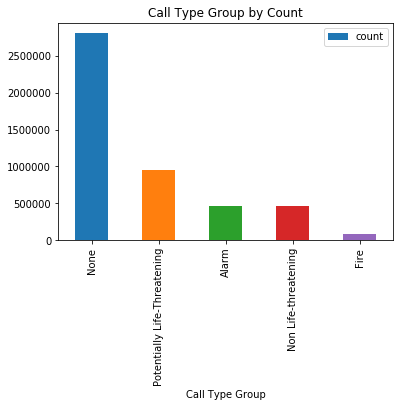

In [8]:
df2 = df.groupBy('Call Type Group').count()
graphDF = df2.toPandas()
graphDF = graphDF.sort_values('count', ascending=False)

graphDF.plot(x='Call Type Group', y = 'count', kind='bar')
plt.title('Call Type Group by Count')
plt.show()

In [9]:
df.groupBy('Call Type').count().orderBy('count', ascending=False).show(100)

+--------------------+-------+
|           Call Type|  count|
+--------------------+-------+
|    Medical Incident|3098884|
|      Structure Fire| 623645|
|              Alarms| 510233|
|   Traffic Collision| 195430|
|               Other|  76290|
|Citizen Assist / ...|  71826|
|        Outside Fire|  56341|
|        Vehicle Fire|  23013|
|        Water Rescue|  22843|
|Gas Leak (Natural...|  18057|
|   Electrical Hazard|  13386|
|Elevator / Escala...|  12528|
|Odor (Strange / U...|  12445|
|Smoke Investigati...|  10555|
|          Fuel Spill|   5540|
|              HazMat|   3915|
|Industrial Accidents|   2829|
|           Explosion|   2582|
|  Aircraft Emergency|   1511|
|       Assist Police|   1331|
|Train / Rail Inci...|   1264|
|   High Angle Rescue|   1172|
|Watercraft in Dis...|    885|
|Extrication / Ent...|    695|
|           Oil Spill|    516|
|Confined Space / ...|    509|
|Mutual Aid / Assi...|    459|
|         Marine Fire|    371|
|  Suspicious Package|    324|
|      A

In [10]:
from pyspark.sql import functions as F
fireIndicator = df.select(df["Call Type"],F.when(df["Call Type"].like("%Fire%"),1)\
                          .otherwise(0).alias('Fire Indicator'))
fireIndicator.show()

+--------------------+--------------+
|           Call Type|Fire Indicator|
+--------------------+--------------+
|    Medical Incident|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|Citizen Assist / ...|             0|
|   Electrical Hazard|             0|
|Odor (Strange / U...|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|               Other|             0|
|    Medical Incident|             0|
|      Structure Fire|             1|
+--------------------+--------------+
only showing top 20 rows



In [11]:
fireIndicator.groupBy('Fire Indicator').count().show()

+--------------+-------+
|Fire Indicator|  count|
+--------------+-------+
|             1| 703393|
|             0|4066287|
+--------------+-------+



In [12]:
df = df.withColumn("fireIndicator", F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))

In [13]:
df.printSchema()

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [14]:
df = df.select('fireIndicator',
    'Zipcode of Incident',
    'Battalion',
    'Station Area',
    'Box',
    'Number of Alarms',
    'Unit sequence in call dispatch',
    'Neighborhooods - Analysis Boundaries',
    'Fire Prevention District',
    'Supervisor District')
df.show(5)

+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
|fireIndicator|Zipcode of Incident|Battalion|Station Area| Box|Number of Alarms|Unit sequence in call dispatch|Neighborhooods - Analysis Boundaries|Fire Prevention District|Supervisor District|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
|            0|              94116|      B08|          18|0757|               1|                             1|                     Sunset/Parkside|                       8|                  4|
|            0|              94122|      B08|          23|7651|               1|                             2|                     Sunset/Parkside|                       8|                  4|
|            0|              9

In [15]:
print('Total Rows')
df.count()

Total Rows


4769680

In [16]:
print('Rows without Null values')
df.dropna().count()

Rows without Null values


4753028

In [17]:
print('Row with Null Values')
df.count()-df.dropna().count()

Row with Null Values


16652

In [18]:
df = df.dropna()

In [19]:
df.groupBy('fireIndicator').count().orderBy('count', ascending = False).show()

+-------------+-------+
|fireIndicator|  count|
+-------------+-------+
|            0|4050744|
|            1| 702284|
+-------------+-------+



In [20]:
from pyspark.ml.feature import StringIndexer

In [21]:
column_names = df.columns[1:]

In [22]:
categoricalColumns = column_names
indexers = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"_Index")
    indexers += [stringIndexer]

In [23]:
models = []
for model in indexers:
    indexer_model = model.fit(df)
    models+=[indexer_model]

for i in models:
    df = i.transform(df)

In [24]:
df = df.select(
        'fireIndicator',
        'Zipcode of Incident_Index',
        'Battalion_Index',
        'Station Area_Index',
        'Box_Index',
        'Number of Alarms_Index',
        'Unit sequence in call dispatch_Index',
        'Neighborhooods - Analysis Boundaries_Index',
        'Fire Prevention District_Index',
        'Supervisor District_Index')

In [25]:
df.printSchema()

root
 |-- fireIndicator: integer (nullable = false)
 |-- Zipcode of Incident_Index: double (nullable = true)
 |-- Battalion_Index: double (nullable = true)
 |-- Station Area_Index: double (nullable = true)
 |-- Box_Index: double (nullable = true)
 |-- Number of Alarms_Index: double (nullable = true)
 |-- Unit sequence in call dispatch_Index: double (nullable = true)
 |-- Neighborhooods - Analysis Boundaries_Index: double (nullable = true)
 |-- Fire Prevention District_Index: double (nullable = true)
 |-- Supervisor District_Index: double (nullable = true)



In [26]:
df.show(5)

+-------------+-------------------------+---------------+------------------+---------+----------------------+------------------------------------+------------------------------------------+------------------------------+-------------------------+
|fireIndicator|Zipcode of Incident_Index|Battalion_Index|Station Area_Index|Box_Index|Number of Alarms_Index|Unit sequence in call dispatch_Index|Neighborhooods - Analysis Boundaries_Index|Fire Prevention District_Index|Supervisor District_Index|
+-------------+-------------------------+---------------+------------------+---------+----------------------+------------------------------------+------------------------------------------+------------------------------+-------------------------+
|            0|                     18.0|            5.0|              29.0|   1740.0|                   0.0|                                 0.0|                                       5.0|                           7.0|                     10.0|
|           

In [27]:
features = df.columns[1:]

In [28]:
from pyspark.ml.feature import VectorAssembler
feature_vectors = VectorAssembler(inputCols = features,outputCol = "features")

In [29]:
df = feature_vectors.transform(df)

In [30]:
df.columns

['fireIndicator',
 'Zipcode of Incident_Index',
 'Battalion_Index',
 'Station Area_Index',
 'Box_Index',
 'Number of Alarms_Index',
 'Unit sequence in call dispatch_Index',
 'Neighborhooods - Analysis Boundaries_Index',
 'Fire Prevention District_Index',
 'Supervisor District_Index',
 'features']

In [31]:
df = df.drop( 'Zipcode of Incident_Index',
              'Battalion_Index',
              'Station Area_Index',
              'Box_Index',
              'Number of Alarms_Index',
              'Unit sequence in call dispatch_Index',
              'Neighborhooods - Analysis Boundaries_Index',
              'Fire Prevention District_Index',
              'Supervisor District_Index')

In [32]:
df = df.withColumnRenamed('fireIndicator', 'label')

In [33]:
df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[18.0,5.0,29.0,17...|
|    0|[8.0,5.0,31.0,127...|
|    0|(9,[1,2,3],[1.0,2...|
|    0|(9,[3,5,7],[7.0,2...|
|    0|[17.0,0.0,0.0,48....|
|    0|[3.0,2.0,1.0,191....|
|    0|[3.0,3.0,17.0,202...|
|    0|[5.0,6.0,18.0,845...|
|    0|[4.0,4.0,7.0,497....|
|    0|[21.0,2.0,4.0,597...|
|    0|[8.0,5.0,26.0,285...|
|    0|[2.0,7.0,3.0,70.0...|
|    0|[7.0,0.0,8.0,251....|
|    0|[6.0,3.0,6.0,241....|
|    0|[6.0,3.0,6.0,241....|
|    0|[18.0,5.0,29.0,10...|
|    0|[22.0,5.0,37.0,39...|
|    0|[11.0,8.0,13.0,13...|
|    1|[5.0,6.0,21.0,282...|
|    0|[1.0,1.0,2.0,46.0...|
+-----+--------------------+
only showing top 20 rows



In [34]:
(trainDF, testDF) = df.randomSplit([0.75, 0.25], seed = 12345)

In [35]:
print(trainDF.count())
print(testDF.count())

3564817
1188211


In [36]:
from pyspark.ml.classification import LogisticRegression
logreg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
LogisticRegressionModel = logreg.fit(trainDF)

In [37]:
df_predicted = LogisticRegressionModel.transform(testDF)

In [38]:
df_predicted.printSchema()

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [39]:
df_predicted.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(9,[0,1,2,3],[1.0...|[2.62764338127542...|[0.93261960974335...|       0.0|
|    0|(9,[0,1,2,3],[1.0...|[2.62764338127542...|[0.93261960974335...|       0.0|
|    0|(9,[0,1,2,3],[1.0...|[2.62764338127542...|[0.93261960974335...|       0.0|
|    0|(9,[0,1,2,3],[1.0...|[2.59663398972153...|[0.93064463453280...|       0.0|
|    0|(9,[0,1,2,3],[1.0...|[2.59663398972153...|[0.93064463453280...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [40]:
df_predicted.crosstab('label', 'prediction').show()

+----------------+-------+-----+
|label_prediction|    0.0|  1.0|
+----------------+-------+-----+
|               1| 126660|48849|
|               0|1004073| 8629|
+----------------+-------+-----+



In [41]:
from sklearn import metrics

In [42]:
actual = df_predicted.select('label').toPandas()
predicted = df_predicted.select('prediction').toPandas()

In [43]:
metrics.accuracy_score(actual, predicted)

0.8861405928744979

In [44]:
df_predicted.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 175509|
|    0|1012702|
+-----+-------+



In [45]:
df_predicted.describe('label').show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|            1188211|
|   mean|0.14770861404245542|
| stddev|0.35481105581711136|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

